# DA6401 Assignment 1  
 
- [GitHub Repository](https://github.com/karan757527/DA6401)  
- [Project Report](https://wandb.ai/cs24m021-iit-madras/DA6401_DL_Assignment1/reports/DA6401-Assignment-1--VmlldzoxMTc4Mzg1Mw)  

### Requirements

In [1]:
!pip install -r requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.datasets import mnist

In [3]:
wandb.login(key="843913992a9025996973825be4ad46e4636d0610")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/karanagrawal/.netrc
wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
PROJECT = "DA6401_Assignment1" #"DA6401_DL_Assignment1"
ENTITY = "karan"
SWEEPCOUNT = 5 #250

### Loading Data

In [5]:
# for question 1-8
(train_img, train_labels), (test_img, test_labels) = fashion_mnist.load_data()
target_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# for question 10
(mnist_train, mnist_train_label), (mnist_test, mnist_test_label) = mnist.load_data()

## Question 1: Plot one sample per class

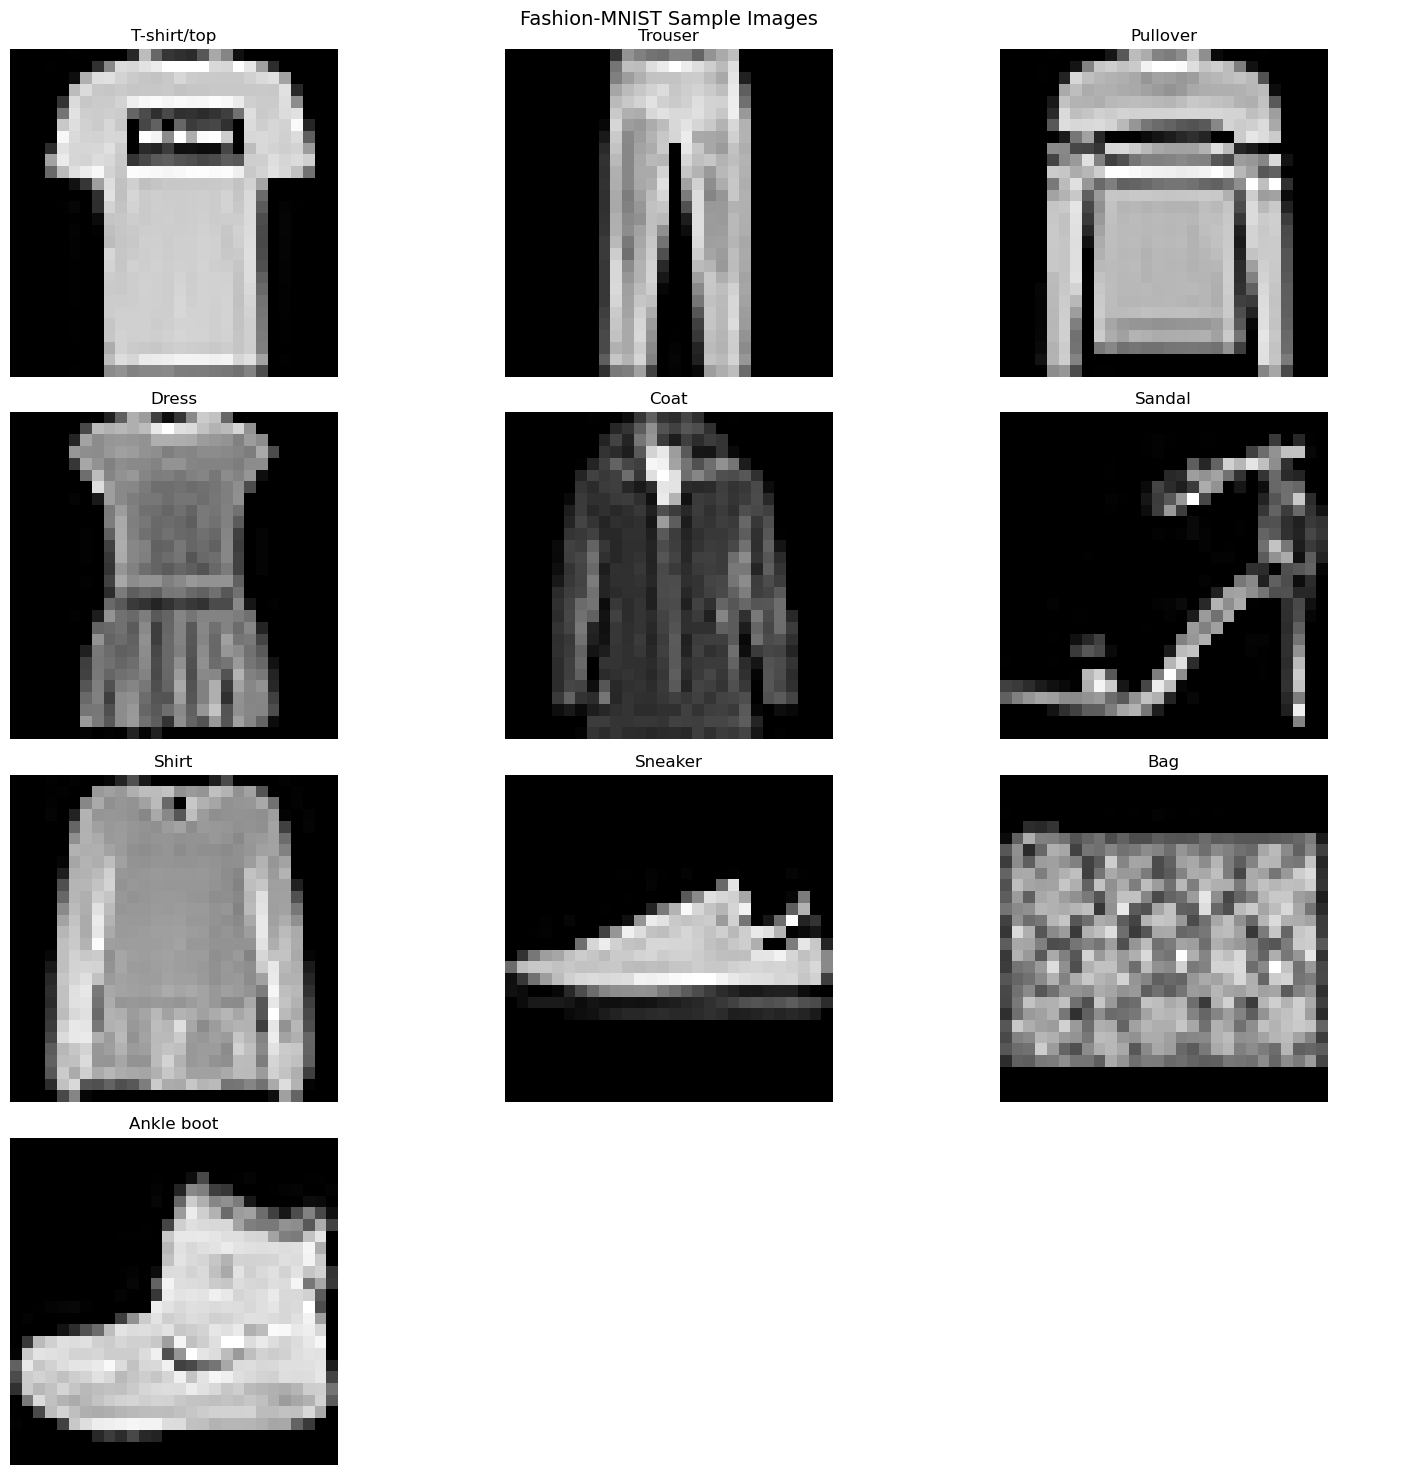

In [6]:
wandb.init(project=PROJECT, name="Question_1")  
sample = []
for id in range(10):
    index = np.where(train_labels == id)[0][0]  # first occurrence of each class
    sample.append(train_img[index])  # corresponding image to the sample list

fig, axes = plt.subplots(4, 3, figsize=(15, 15))  
fig.suptitle("Fashion-MNIST Sample Images", fontsize=14)  

for i, ax in enumerate(axes.flat):
    if i < len(sample):
        ax.imshow(sample[i], cmap='gray')  # display the image in grayscale
        ax.set_title(target_classes[i]) 
        ax.axis("off") 
    else:
        ax.axis("off")  

plt.tight_layout() 
wandb.log({"Sample_Images": wandb.Image(plt)})  # logging to wandb
plt.show()
wandb.finish(); 

### Activation Functions

In [7]:
class Activation_Functions:
    def __init__(self):
        self.activation_functions = {
            "tanh": self.tanh,
            "sigmoid": self.sigmoid,
            "ReLU": self.ReLU,
            "softmax": self.softmax,
            "identity": self.identity
        }

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)  # softmax probabilities
        
    def sigmoid(self, x):
        result = np.zeros_like(x)
        result[x >= 0] = 1 / (1 + np.exp(-x[x >= 0]))  # for positive values
        result[x < 0] = np.exp(x[x < 0]) / (1 + np.exp(x[x < 0]))  # for negative values
        return result

    def ReLU(self, x):
        return np.maximum(0, x)  # ReLU activation

    def tanh(self, x):
        return np.tanh(x)  # hyperbolic tangent activation

    def identity(self, x):
        return x  # identity function

    def activation(self, x, fun):
        activation_function = self.activation_functions.get(fun)
        if activation_function:
            return activation_function(x)
        else:
            raise ValueError(f"Activation function '{fun}' is not supported.")

### Loss Functions

In [8]:
class Loss_Function:
    def __init__(self):
        pass

    def compute_loss(self, y_true, y_pred, loss_function="cross_entropy"):
        if loss_function == "cross_entropy":
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # clip to avoid log(0)
            return np.mean(-np.sum(y_true * np.log(y_pred), axis=1))  # cross-entropy loss
        if loss_function == "mean_squared_error":
            return 0.5 * np.mean(np.sum((y_true - y_pred) ** 2, axis=1))  # MSE loss

    def last_output_derivative(self, y_pred, y_true, activation_derivative, loss_function="cross_entropy"):
        if loss_function == "mean_squared_error":
            return (y_pred - y_true) * activation_derivative / len(y_true)  # MSE derivative
        if loss_function == "cross_entropy":
            return -(y_true - y_pred)  # cross-entropy derivative

### Derivatioves

In [9]:
class Derivatives:
    def __init__(self):
        self.activation = Activation_Functions()
        self.derivative_functions = {
            "sigmoid": self.sigmoid_derivative,
            "tanh": self.tanh_derivative,
            "ReLU": self.ReLU_derivative,
            "softmax": self.softmax_derivative,
            "identity": self.identity_derivative
        }

    def sigmoid_derivative(self, x):
        k = self.activation.sigmoid(x)
        return k * (1 - k)  # derivative of sigmoid

    def softmax_derivative(self, x):
        k = self.activation.softmax(x)
        return k * (1 - k)  # derivative of softmax

    def tanh_derivative(self, x):
        k = self.activation.tanh(x)
        return 1 - k ** 2  # derivative of tanh

    def ReLU_derivative(self, x):
        x[x > 0] = 1  # derivative is 1 for x > 0
        x[x <= 0] = 0  # derivative is 0 for x <= 0
        return x

    def identity_derivative(self, x):
        return np.ones_like(x)  # derivative of identity is 1

    def derivatives(self, x, activation_function):
        derivative_function = self.derivative_functions.get(activation_function)
        if derivative_function:
            return derivative_function(x)
        else:
            raise ValueError(f"Derivative for activation function '{activation_function}' is not supported.")

## Question 2

In [10]:
def forward_pass(x, weights, biases, activation, layer_sizes):
    activation_func = Activation_Functions()
    outputs, activations = {}, {}
    outputs[0] = x  # input layer
    
    num_layers = len(layer_sizes)
    
    for layer in range(1, num_layers - 1):
        activations[layer] = np.dot(outputs[layer - 1], weights[layer]) + biases[layer]  # linear transformation
        outputs[layer] = activation_func.activation(activations[layer], fun=activation)  # apply activation
    
    activations[num_layers - 1] = np.dot(outputs[num_layers - 2], weights[num_layers - 1]) + biases[num_layers - 1]
    outputs[num_layers - 1] = activation_func.activation(activations[num_layers - 1], fun="softmax")  # softmax for output layer
    
    return outputs[num_layers - 1]  # final output

def Network_Q2(data, activation, input_size, layers, output_size):
    weights, biases = {}, {}
    layer_sizes = [input_size] + layers + [output_size]  # define layer sizes
    predicted_probs = []
    
    for layer in range(1, len(layer_sizes)):
        weights[layer] = np.random.randn(layer_sizes[layer - 1], layer_sizes[layer])  # initialize weights
        biases[layer] = np.random.randn(1, layer_sizes[layer])  # initialize biases
    
    for sample in data:
        x = sample.reshape(1, -1) / 255.0  # normalize input
        y_pred = forward_pass(x, weights, biases, activation, layer_sizes)  # forward pass
        predicted_probs.append(y_pred)  # store predictions
    
    return predicted_probs  # return all predictions

In [11]:
y_pred_Q2 = Network_Q2(train_img, "sigmoid", 784, [32, 32, 32], 10)  
print(np.array(y_pred_Q2[:5]).round(6))  # print first 5 predictions

[[[1.36000e-03 2.97000e-04 9.99060e-02 8.88156e-01 1.20000e-05
   3.34200e-03 2.48800e-03 1.16000e-03 4.00000e-06 3.27400e-03]]

 [[7.13700e-03 1.90270e-02 5.77940e-01 1.91462e-01 1.51000e-04
   3.47710e-02 1.05657e-01 5.89650e-02 2.67000e-04 4.62400e-03]]

 [[3.51600e-03 3.82000e-04 4.63640e-01 5.17520e-01 1.00000e-05
   2.34500e-03 9.44200e-03 2.65800e-03 2.50000e-05 4.62000e-04]]

 [[3.38050e-02 1.00830e-02 5.53862e-01 3.11355e-01 8.60000e-05
   2.42060e-02 3.72010e-02 2.50880e-02 2.86000e-04 4.02700e-03]]

 [[4.67780e-02 1.59100e-03 3.85896e-01 4.96653e-01 2.60000e-05
   1.28030e-02 3.74600e-02 1.61560e-02 1.37000e-04 2.50000e-03]]]


### Optimizers

In [12]:
class Optimizer:
    def __init__(self, model, config):
        self.model = model  
        self.learning_rate = config["eta"]  
        self.decay = config["weight_decay"]  
        self.optim_type = config["optimizer"]  
        self.momentum = config["momentum"] 
        self.beta1 = config["beta1"] 
        self.beta2 = config["beta2"]  
        self.epsilon_val = config["epsilon"]
        self.optimization_methods = {
            "sgd": self.stochastic_gradient_descent,
            "momentum": self.momentum_gradient_descent,
            "nesterov": self.nesterov_gradient_descent,
            "nag": self.nesterov_gradient_descent,
            "rmsprop": self.rmsprop,
            "adam": self.adam,
            "nadam": self.nadam
        }

    def update_parameters(self, timestep):
        optimization_function = self.optimization_methods.get(self.optim_type)
        
        if optimization_function:
            if self.optim_type in ["adam", "nadam"]:
                optimization_function(timestep)
            else:
                optimization_function()
        else:
            raise ValueError(f"Optimization method '{self.optim_type}' is not supported.")

    def stochastic_gradient_descent(self):
        param_layers = self.model.weights.keys()
        for l in param_layers:
            reg_term = self.model.weights[l] * self.decay  # weight decay
            self.model.grad_weights[l] += reg_term
            bias_update = self.learning_rate * self.model.grad_biases[l]  # bias update
            self.model.biases[l] -= bias_update
            weight_update = self.learning_rate * self.model.grad_weights[l]  # weight update
            self.model.weights[l] -= weight_update

    def momentum_gradient_descent(self):
        for layer in self.model.weights.keys():
            self.model.grad_weights[layer] += self.decay * self.model.weights[layer]  # weight decay
            prev_momentum_w = self.momentum * self.model.m_weights[layer]
            new_momentum_w = prev_momentum_w + self.learning_rate * self.model.grad_weights[layer]  # momentum update
            prev_momentum_b = self.momentum * self.model.m_biases[layer]
            new_momentum_b = prev_momentum_b + self.learning_rate * self.model.grad_biases[layer]
            self.model.m_weights[layer] = new_momentum_w
            self.model.m_biases[layer] = new_momentum_b
            self.model.weights[layer] -= new_momentum_w
            self.model.biases[layer] -= new_momentum_b

    def nesterov_gradient_descent(self):
        for l in self.model.weights.keys():
            momentum_w = self.momentum * self.model.m_weights[l]  # momentum term
            lookahead_w = self.model.weights[l] - momentum_w  # lookahead step
            lookahead_b = self.model.biases[l] - self.momentum * self.model.m_biases[l]
            self.model.grad_weights[l] += lookahead_w * self.decay  # weight decay
            grad_w = self.model.grad_weights[l]
            grad_b = self.model.grad_biases[l]
            new_m_w = self.momentum * self.model.m_weights[l] - self.learning_rate * grad_w  # update momentum
            new_m_b = self.momentum * self.model.m_biases[l] - self.learning_rate * grad_b
            self.model.weights[l] += new_m_w
            self.model.biases[l] += new_m_b
            self.model.m_weights[l] = new_m_w
            self.model.m_biases[l] = new_m_b

    def rmsprop(self):
        for layer in self.model.weights.keys():
            current_grad_w = self.model.grad_weights[layer] + self.model.weights[layer] * self.decay  # weight decay
            current_grad_b = self.model.grad_biases[layer]
            self.model.v_weights[layer] = self.beta2*self.model.v_weights[layer] + (1-self.beta2)*(current_grad_w**2)  # velocity update
            self.model.v_biases[layer] = self.beta2*self.model.v_biases[layer] + (1-self.beta2)*(current_grad_b**2)
            epsilon = 1e-8 if self.epsilon_val < 1e-8 else self.epsilon_val  # numerical stability
            self.model.weights[layer] -= (current_grad_w * self.learning_rate) / (np.sqrt(self.model.v_weights[layer]) + epsilon)  # update weights
            self.model.biases[layer] -= (current_grad_b * self.learning_rate) / (np.sqrt(self.model.v_biases[layer]) + epsilon)

    def adam(self, step):
        for l in self.model.weights.keys():
            decay_contribution = self.decay * self.model.weights[l] # weight decay
            self.model.grad_weights[l] += decay_contribution
            
            grad_w = np.clip(self.model.grad_weights[l], -1e3, 1e3)
            grad_b = np.clip(self.model.grad_biases[l], -1e3, 1e3)
            
            m_w = self.beta1 * self.model.m_weights[l] + (1 - self.beta1) * grad_w # momentum update with numerical stability
            m_b = self.beta1 * self.model.m_biases[l] + (1 - self.beta1) * grad_b
            
            v_w = self.beta2 * self.model.v_weights[l] + (1 - self.beta2) * (grad_w**2 + 1e-8)
            v_b = self.beta2 * self.model.v_biases[l] + (1 - self.beta2) * (grad_b**2 + 1e-8)
            
            self.model.m_weights[l], self.model.v_weights[l] = m_w, v_w
            self.model.m_biases[l], self.model.v_biases[l] = m_b, v_b
            
            beta1_t = max(self.beta1**step, 1e-8)
            beta2_t = max(self.beta2**step, 1e-8)
            mw_corrected = m_w / (1 - beta1_t + 1e-8)
            vw_corrected = v_w / (1 - beta2_t + 1e-8)
            mb_corrected = m_b / (1 - beta1_t + 1e-8)
            vb_corrected = v_b / (1 - beta2_t + 1e-8)
            
            weight_update = self.learning_rate * mw_corrected / (np.sqrt(vw_corrected) + self.epsilon_val)
            bias_update = self.learning_rate * mb_corrected / (np.sqrt(vb_corrected) + self.epsilon_val)
            
            self.model.weights[l] -= np.clip(weight_update, -1e3, 1e3)
            self.model.biases[l] -= np.clip(bias_update, -1e3, 1e3)

    def nadam(self, step):
        for l in self.model.weights.keys():
            self.model.grad_weights[l] += self.model.weights[l] * self.decay
            grad_w = np.clip(self.model.grad_weights[l], -1e3, 1e3)
            grad_b = np.clip(self.model.grad_biases[l], -1e3, 1e3)
            
            m_w_new = self.beta1 * self.model.m_weights[l] + (1-self.beta1)*grad_w
            m_b_new = self.beta1 * self.model.m_biases[l] + (1-self.beta1)*grad_b

            v_w_new = self.beta2 * self.model.v_weights[l] + (1-self.beta2)*(grad_w**2 + 1e-8)
            v_b_new = self.beta2 * self.model.v_biases[l] + (1-self.beta2)*(grad_b**2 + 1e-8)
            
            beta1_t = max(self.beta1**step, 1e-8)
            beta2_t = max(self.beta2**step, 1e-8)
            mw_hat = m_w_new / (1 - beta1_t + 1e-8)
            vw_hat = v_w_new / (1 - beta2_t + 1e-8)
            mb_hat = m_b_new / (1 - beta1_t + 1e-8)
            vb_hat = v_b_new / (1 - beta2_t + 1e-8)
            
            nesterov_w = self.beta1 * mw_hat + (1-self.beta1)*grad_w/(1 - beta1_t + 1e-8)
            nesterov_b = self.beta1 * mb_hat + (1-self.beta1)*grad_b/(1 - beta1_t + 1e-8)
            
            weight_update = self.learning_rate * nesterov_w / (np.sqrt(vw_hat) + self.epsilon_val)
            bias_update = self.learning_rate * nesterov_b / (np.sqrt(vb_hat) + self.epsilon_val)
            
            self.model.weights[l] -= np.clip(weight_update, -1e3, 1e3)
            self.model.biases[l] -= np.clip(bias_update, -1e3, 1e3)
            
            self.model.m_weights[l], self.model.v_weights[l] = m_w_new, v_w_new
            self.model.m_biases[l], self.model.v_biases[l] = m_b_new, v_b_new

### Final Neural Network Functionalities

In [13]:
class Neural_Network:
    def __init__(self, config, log=1, console=1):
        self.weights, self.biases, self.a, self.h = {}, {}, {}, {}
        self.grad_weights, self.grad_biases, self.m_weights, self.m_biases = {}, {}, {}, {}
        self.v_weights, self.v_biases = {}, {}

        self.activation_function = config["activation_function"]
        self.loss_function = config["loss_function"]
        self.initialization = config["init"]
        self.hidden_layers = config["hidden_layers"]
        self.hidden_layer_sizes = config["hidden_layer_sizes"]
        self.dataset = config["dataset"]
        self.wan_log, self.console_log = log, console
        self.loss = Loss_Function()
        self.act = Activation_Functions()
        self.derivative = Derivatives()

        (train_img, train_lbl), (test_img, test_lbl) = self.load_dataset()
        train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.1, random_state=41)

        self.input, self.y_true = self.preprocess_data(train_img, train_lbl)  # preprocess training data
        self.val_img, self.val_true = self.preprocess_data(val_img, val_lbl)  # preprocess validation data
        self.test_img, self.test_true = self.preprocess_data(test_img, test_lbl)  # preprocess test data
        self.layers = [self.input.shape[1]] + [self.hidden_layer_sizes] * self.hidden_layers + [10]  
        
        self.initialize_parameters()  # initialize weights and biases

    def load_dataset(self):
        if self.dataset == 'fashion_mnist':
            return (train_img, train_labels), (test_img, test_labels)
        if self.dataset == 'mnist':
            return (mnist_train, mnist_train_label), (mnist_test, mnist_test_label)
        else:
            raise ValueError("Unknown dataset")

    def preprocess_data(self, images, labels):
        return images.reshape(images.shape[0], -1) / 255.0 , labels  # normalize and reshape data

    def initialize_parameters(self):
        for layer in range(1, len(self.layers)):
            self.v_weights[layer] = np.zeros((self.layers[layer-1], self.layers[layer]))  # initialize velocity for weights
            self.v_biases[layer] = np.zeros((1, self.layers[layer]))  # initialize velocity for biases
            
            self.m_weights[layer] = np.zeros((self.layers[layer-1], self.layers[layer]))  # initialize momentum for weights
            self.m_biases[layer] = np.zeros((1, self.layers[layer]))  # initialize momentum for biases
            
            if self.initialization == "random":
                self.weights[layer] = np.random.normal(0, 1, (self.layers[layer-1], self.layers[layer]))
                self.biases[layer] = np.random.normal(0, 1, (1, self.layers[layer]))
            elif self.initialization == "Xavier":
                scale_w = np.sqrt(2.0 / (self.layers[layer-1] + self.layers[layer]))
                scale_b = np.sqrt(2.0 / (1 + self.layers[layer]))
                self.weights[layer] = np.random.normal(0, scale_w, (self.layers[layer-1], self.layers[layer]))
                self.biases[layer] = np.random.normal(0, scale_b, (1, self.layers[layer]))

    def forward_propagation(self, x):
        self.h[0] = x
        num_layers = len(self.layers) - 1
    
        for layer in range(1, num_layers):
            linear_output = self.h[layer-1] @ self.weights[layer]
            self.a[layer] = linear_output + self.biases[layer]   # linear transformation
            self.h[layer] = self.act.activation(self.a[layer], self.activation_function)
    
        final_linear_output = self.h[num_layers-1] @ self.weights[num_layers]
        self.a[num_layers] = final_linear_output + self.biases[num_layers]
        self.h[num_layers] = self.act.activation(self.a[num_layers], "softmax") # softmax for output layer
    
        output = self.h[num_layers]
        return output

    def backward_propagation(self, x, y_true, y_hat): 
        output_layer_index = len(self.layers) - 1  # softmax derivative for output layer  
        softmax_grad = self.derivative.derivatives(self.a[output_layer_index], "softmax")  
        error = self.loss.last_output_derivative(y_hat, y_true, softmax_grad, self.loss_function)  
    
        # for hidden layers
        for current_layer in reversed(range(2, len(self.layers))):  
            prev_hidden = self.h[current_layer - 1]  
    
            self.grad_weights[current_layer] = prev_hidden.T @ error  
            self.grad_biases[current_layer] = np.sum(error, axis=0, keepdims=True)  
    
            weight_matrix = self.weights[current_layer].T  
            error_hidden = error @ weight_matrix  
            deriv_activation = self.derivative.derivatives(self.a[current_layer - 1], self.activation_function)  
            error = error_hidden * deriv_activation  
    
        input_grad_weights = x.T @ error  
        input_grad_biases = np.sum(error, axis=0, keepdims=True)  
        self.grad_weights[1] = input_grad_weights  
        self.grad_biases[1] = input_grad_biases  

    def one_hot_matrix(self, labels):
        mat = np.zeros((labels.shape[0], 10)) 
        mat[np.arange(labels.shape[0]), labels] = 1
        return mat

    def compute_performance(self, data, labels):
        y_pred = self.forward_propagation(data)  # forward pass
        one_hot_labels = self.one_hot_matrix(labels)  # convert labels to one-hot
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(one_hot_labels, axis=1)) * 100 
        loss = self.loss.compute_loss(one_hot_labels, y_pred, self.loss_function)  
        return loss, accuracy

    
    def probability(self, data):
        return self.forward_propagation(data)  

        
    def fit(self, batch_size, epochs, optimizer):  
        num_samples = self.input.shape[0]  
        num_mini_batches = int(np.ceil(num_samples / batch_size))  # total batches  
    
        for epoch_num in range(epochs):  
            step_counter = 1  
    
            for iteration in range(num_mini_batches):  
                start_idx = iteration * batch_size  
                end_idx = min(start_idx + batch_size, num_samples)  
                batch_images = self.input[start_idx:end_idx]  
                batch_labels = self.y_true[start_idx:end_idx]  
    
                predictions = self.forward_propagation(batch_images)  # forward and backward pass  
                true_labels_one_hot = self.one_hot_matrix(batch_labels)  
                self.backward_propagation(batch_images, true_labels_one_hot, predictions)  
     
                for layer_idx in self.grad_weights.keys():  
                    self.grad_weights[layer_idx] = self.grad_weights[layer_idx] / batch_size  
                    self.grad_biases[layer_idx] = self.grad_biases[layer_idx] / batch_size  
      
                optimizer.update_parameters(step_counter)  
                step_counter = step_counter + 1  
    
            training_loss, training_acc = self.compute_performance(self.input, self.y_true)  
            val_loss, val_acc = self.compute_performance(self.val_img, self.val_true)  
    
            log_data = {  
                'epoch': epoch_num + 1,  
                'train_loss': training_loss,  
                'train_acc': training_acc,  
                'val_loss': val_loss,  
                'val_acc': val_acc  
            }  
    
            if self.wan_log:  
                wandb.log(log_data)  # log to wandb  
    
            if self.console_log:  
                status_msg = (  
                    f"Epoch {epoch_num + 1}: "  
                    f"Train Loss={training_loss:.4f}, "  
                    f"Train Acc={training_acc:.2f}%, "  
                    f"Val Loss={val_loss:.4f}, "  
                    f"Val Acc={val_acc:.2f}%"  
                )  
                print(status_msg)  
    
        return training_loss, training_acc, val_loss, val_acc  

## Question 3

In [14]:
for opt in ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]:
    print("Optimiser: " + opt + "\n")
    config_nn = {
        "activation_function": "sigmoid",  
        "init": "random",
        "dataset": "fashion_mnist",
        "loss_function": "cross_entropy", 
        "hidden_layers": 4,
        "hidden_layer_sizes": 128
        
    }
    
    config_opt = {
        "optimizer": f"{opt}",
        "eta": 0.005,  
        "beta": 0.9,
        "beta2": 0.999,
        "beta1": 0.9,
        "weight_decay": 0.0005,
        "epsilon": 1e-8,
        "momentum": 0.9
    }
    
    nn = Neural_Network(config_nn, log=0, console=1)
    optimizer = Optimizer(nn, config_opt)
    
    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=64, epochs=5, optimizer=optimizer)
    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
    print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
    print()
    print()


Optimiser: sgd

Epoch 1: Train Loss=1.6643, Train Acc=43.83%, Val Loss=1.6599, Val Acc=43.70%
Epoch 2: Train Loss=1.3355, Train Acc=53.45%, Val Loss=1.3336, Val Acc=53.43%
Epoch 3: Train Loss=1.1828, Train Acc=58.29%, Val Loss=1.1819, Val Acc=58.13%
Epoch 4: Train Loss=1.0887, Train Acc=61.30%, Val Loss=1.0886, Val Acc=61.00%
Epoch 5: Train Loss=1.0226, Train Acc=63.51%, Val Loss=1.0235, Val Acc=63.17%
Test Loss: 1.0571, Test Acc: 61.96%


Optimiser: momentum

Epoch 1: Train Loss=0.8569, Train Acc=69.80%, Val Loss=0.8717, Val Acc=68.75%
Epoch 2: Train Loss=0.7188, Train Acc=74.41%, Val Loss=0.7395, Val Acc=73.35%
Epoch 3: Train Loss=0.6562, Train Acc=76.48%, Val Loss=0.6784, Val Acc=75.27%
Epoch 4: Train Loss=0.6164, Train Acc=77.90%, Val Loss=0.6398, Val Acc=76.87%
Epoch 5: Train Loss=0.5879, Train Acc=78.87%, Val Loss=0.6127, Val Acc=77.78%
Test Loss: 0.6345, Test Acc: 76.70%


Optimiser: nesterov

Epoch 1: Train Loss=0.8360, Train Acc=70.58%, Val Loss=0.8638, Val Acc=69.73%
Epoch 2:

## Question 4

In [15]:
# sweep configuration as specified in question maximizing test accuracy
sweep_config = {
    "method": "bayes",  
    "project": f"{PROJECT}",
    "metric": {"name": "test_accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_sizes": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]},
        "initialization": {"values": ["Xavier", "random"]},
        "dataset": {"values": ["fashion_mnist"]}
    }
}

In [16]:
# to call inside wandb.agent()
def train(loss_function):
    sw = wandb.init(project = PROJECT)
    sw = sw.config

    wandb.run.name = f"opt_{sw.optimizer}_hl_{sw.hidden_layers}_bs_{sw.batch_size}_e_{sw.epochs}_act_{sw.activation}_eta_{sw.learning_rate}_init_{sw.initialization}_hls_{sw.hidden_layer_sizes}_dataset_{sw.dataset}_{loss_function}"
    # Example: opt_adam_hl_4_bs_32_e_10_act_ReLU_eta_0.001_init_Xavier_hls_64_dataset_fashion_mnist_cross_entropy
    
    config_nn = {
        "activation_function": sw.activation, 
        "init" : sw.initialization, 
        "dataset" : sw.dataset,
        "loss_function" : loss_function,
        "hidden_layers": sw.hidden_layers,
        "hidden_layer_sizes" : sw.hidden_layer_sizes
    }

    config_opt = {
        "optimizer": sw.optimizer,
        "eta": sw.learning_rate,
        "beta1" : 0.9,
        "beta2" : 0.999,
        "beta": 0.9,
        "weight_decay": sw.weight_decay,
        "epsilon": 1e-8,
        "momentum" : 0.9
    }

    nn = Neural_Network(config_nn,log = 1,console=1)
    opt = Optimizer(nn, config_opt)

    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=sw.batch_size, epochs=sw.epochs, optimizer=opt)

    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
    print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
    wandb.log({"test_accuracy" : accuracy})
    

In [17]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train(loss_function = "cross_entropy"), count = SWEEPCOUNT)
wandb.finish()

Create sweep with ID: eb4wz51v
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_Assignment1/sweeps/eb4wz51v


wandb: Agent Starting Run: nkylpwd7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4519, Train Acc=83.81%, Val Loss=0.4688, Val Acc=83.22%
Epoch 2: Train Loss=0.3909, Train Acc=85.53%, Val Loss=0.4120, Val Acc=84.78%
Epoch 3: Train Loss=0.3701, Train Acc=86.43%, Val Loss=0.3925, Val Acc=85.17%
Epoch 4: Train Loss=0.3485, Train Acc=87.18%, Val Loss=0.3699, Val Acc=86.45%
Epoch 5: Train Loss=0.3435, Train Acc=87.33%, Val Loss=0.3659, Val Acc=86.25%
Test Loss: 0.3968, Test Acc: 85.47%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆██
train_loss,█▄▃▁▁
val_acc,▁▄▅██
val_loss,█▄▃▁▁
epoch,5
test_accuracy,85.47
train_acc,87.33333
train_loss,0.34346
val_acc,86.25


wandb: Agent Starting Run: nts4sxmn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4922, Train Acc=82.26%, Val Loss=0.4988, Val Acc=81.60%
Epoch 2: Train Loss=0.4319, Train Acc=84.55%, Val Loss=0.4393, Val Acc=83.67%
Epoch 3: Train Loss=0.4020, Train Acc=85.58%, Val Loss=0.4120, Val Acc=84.92%
Epoch 4: Train Loss=0.3821, Train Acc=86.25%, Val Loss=0.3942, Val Acc=85.68%
Epoch 5: Train Loss=0.3669, Train Acc=86.88%, Val Loss=0.3807, Val Acc=86.23%
Test Loss: 0.4156, Test Acc: 85.12%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,85.12
train_acc,86.87593
train_loss,0.36688
val_acc,86.23333


wandb: Agent Starting Run: ns78kauc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.4272, Train Acc=9.98%, Val Loss=2.4225, Val Acc=10.15%
Epoch 2: Train Loss=2.3910, Train Acc=9.98%, Val Loss=2.3869, Val Acc=10.15%
Epoch 3: Train Loss=2.3662, Train Acc=9.98%, Val Loss=2.3626, Val Acc=10.15%
Epoch 4: Train Loss=2.3487, Train Acc=9.98%, Val Loss=2.3456, Val Acc=10.15%
Epoch 5: Train Loss=2.3361, Train Acc=9.98%, Val Loss=2.3334, Val Acc=10.15%
Test Loss: 2.3358, Test Acc: 10.00%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,█▅▃▂▁
val_acc,▁▁▁▁▁
val_loss,█▅▃▂▁
epoch,5
test_accuracy,10
train_acc,9.98333
train_loss,2.33614
val_acc,10.15


wandb: Agent Starting Run: zze6y5yr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3061, Train Acc=9.99%, Val Loss=2.3063, Val Acc=10.12%
Epoch 2: Train Loss=2.3059, Train Acc=9.99%, Val Loss=2.3059, Val Acc=10.12%
Epoch 3: Train Loss=2.3057, Train Acc=9.99%, Val Loss=2.3057, Val Acc=10.12%
Epoch 4: Train Loss=2.3056, Train Acc=9.99%, Val Loss=2.3056, Val Acc=10.12%
Epoch 5: Train Loss=2.3055, Train Acc=9.99%, Val Loss=2.3054, Val Acc=10.12%
Epoch 6: Train Loss=2.3054, Train Acc=9.99%, Val Loss=2.3053, Val Acc=10.12%
Epoch 7: Train Loss=2.3053, Train Acc=9.99%, Val Loss=2.3052, Val Acc=10.12%
Epoch 8: Train Loss=2.3052, Train Acc=9.99%, Val Loss=2.3051, Val Acc=10.12%
Epoch 9: Train Loss=2.3051, Train Acc=9.99%, Val Loss=2.3050, Val Acc=10.12%
Epoch 10: Train Loss=2.3051, Train Acc=9.99%, Val Loss=2.3049, Val Acc=10.12%
Test Loss: 2.3051, Test Acc: 10.00%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▄▃▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,2.30508
val_acc,10.11667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 30lxfn1x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3078, Train Acc=9.99%, Val Loss=2.3069, Val Acc=10.12%
Epoch 2: Train Loss=2.3073, Train Acc=9.99%, Val Loss=2.3063, Val Acc=10.12%
Epoch 3: Train Loss=2.3069, Train Acc=9.99%, Val Loss=2.3058, Val Acc=10.12%
Epoch 4: Train Loss=2.3066, Train Acc=9.99%, Val Loss=2.3055, Val Acc=10.12%
Epoch 5: Train Loss=2.3064, Train Acc=9.99%, Val Loss=2.3052, Val Acc=10.12%
Test Loss: 2.3063, Test Acc: 10.00%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,█▆▄▂▁
val_acc,▁▁▁▁▁
val_loss,█▆▄▂▁
epoch,5
test_accuracy,10
train_acc,9.98704
train_loss,2.3064
val_acc,10.11667


## Question 5
Plot can be seen [here](https://wandb.ai/cs24m021-iit-madras/DA6401_DL_Assignment1/reports/DA6401-Assignment-1--VmlldzoxMTc4Mzg1Mw)  

## Question 6
Plot can be seen [here](https://wandb.ai/cs24m021-iit-madras/DA6401_DL_Assignment1/reports/DA6401-Assignment-1--VmlldzoxMTc4Mzg1Mw)  

## Question 7

In [18]:
def generate_and_plot_confusion_matrix(y_pred, y_true):  
    
    wandb.init(project=PROJECT, name="Question:7")  
    
    predicted_classes = np.argmax(y_pred, axis=1)   # predicted classes 
    num_labels = len(target_classes)  
    conf_matrix = np.zeros((num_labels, num_labels), dtype=int)  
      
    for idx, actual_label in enumerate(y_true):  
        true_idx = int(actual_label)  
        pred_idx = int(predicted_classes[idx])  
        
        if (true_idx >= 0 and true_idx < num_labels) and (pred_idx >= 0 and pred_idx < num_labels):  
            conf_matrix[true_idx, pred_idx] += 1  
        else:  
            print(f"Skipping invalid index: y_true={true_idx}, y_pred={pred_idx}")  
    
    df_confusion = pd.DataFrame(conf_matrix, index=target_classes, columns=target_classes)  

    
    fig = plt.figure(figsize=(15, 15))  # plot heatmap  
    ax = sns.heatmap(  
        df_confusion,  
        annot=True,  
        fmt='d',  
        cmap="Reds",  
        linewidths=4,  
        linecolor='white'  
    )  
    ax.set_xlabel("Predicted Class")  
    ax.set_ylabel("True Class")  
    ax.set_xticklabels(target_classes, rotation=90)  
    ax.set_yticklabels(target_classes, rotation=0)  
    plt.title('Confusion Matrix', fontsize=12)  
    
    plt.show()  
    wandb.log({"conf_mat": wandb.plot.confusion_matrix(probs=None,
                                                       y_true=y_true, 
                                                       preds=predicted_classes,
                                                       class_names=target_classes)})  
    wandb.finish()  

Epoch 1: Train Loss=0.4038, Train Acc=85.53%, Val Loss=0.4089, Val Acc=85.23%
Epoch 2: Train Loss=0.3613, Train Acc=87.04%, Val Loss=0.3714, Val Acc=86.68%
Epoch 3: Train Loss=0.3361, Train Acc=87.80%, Val Loss=0.3516, Val Acc=87.20%
Epoch 4: Train Loss=0.3219, Train Acc=88.24%, Val Loss=0.3421, Val Acc=87.77%
Epoch 5: Train Loss=0.3093, Train Acc=88.71%, Val Loss=0.3336, Val Acc=88.03%
Epoch 6: Train Loss=0.2973, Train Acc=89.12%, Val Loss=0.3258, Val Acc=88.55%
Epoch 7: Train Loss=0.2912, Train Acc=89.39%, Val Loss=0.3232, Val Acc=88.57%
Epoch 8: Train Loss=0.2799, Train Acc=89.81%, Val Loss=0.3164, Val Acc=88.98%
Epoch 9: Train Loss=0.2700, Train Acc=90.09%, Val Loss=0.3100, Val Acc=89.17%
Epoch 10: Train Loss=0.2652, Train Acc=90.26%, Val Loss=0.3091, Val Acc=89.18%
Test Loss: 0.3561, Test Acc: 87.45%


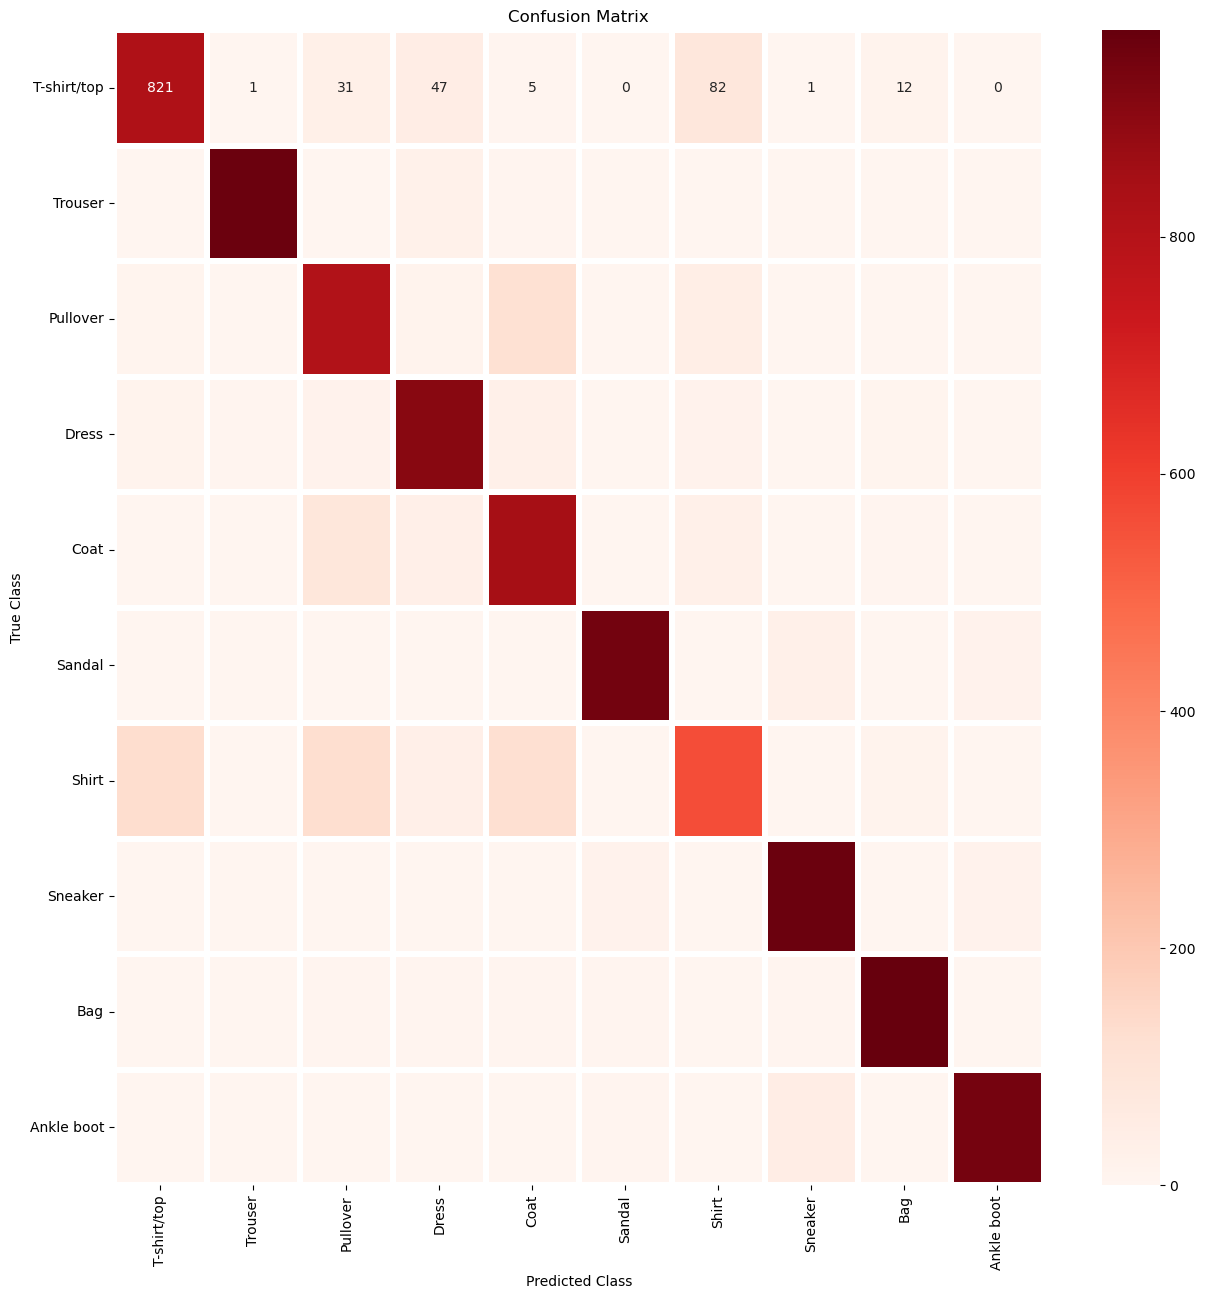

In [19]:
# best config was opt_rmsprop_hl_4_bs_16_e_10_act_ReLU_eta_0.0001_init_Xavier_hls_128_dataset_fashion_mnist_cross_entropy
config_nn = {
        "activation_function": "ReLU",  
        "init": "Xavier",
        "dataset": "fashion_mnist",
        "loss_function": "cross_entropy", 
        "hidden_layers": 4,
        "hidden_layer_sizes": 128
        
}

config_opt = {
    "optimizer": "rmsprop",
    "eta": 0.0001,  
    "beta": 0.9,
    "beta2": 0.999,
    "beta1": 0.9,
    "weight_decay": 0.0005,
    "epsilon": 1e-8,
    "momentum": 0.9
}

nn = Neural_Network(config_nn, log=0, console=1)
optimizer = Optimizer(nn, config_opt)

t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=16, epochs=10, optimizer=optimizer)
loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
y_pred = nn.probability(nn.test_img)
generate_and_plot_confusion_matrix(y_pred, nn.test_true) # plot confusion matrox

## Question 8

In [22]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train(loss_function = "mean_squared_error"), count = SWEEPCOUNT)
wandb.finish()

Create sweep with ID: 70qqsb2h
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_Assignment1/sweeps/70qqsb2h


wandb: Agent Starting Run: mn9bn1zr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.8293, Train Acc=6.67%, Val Loss=0.8292, Val Acc=6.63%
Epoch 2: Train Loss=0.8292, Train Acc=6.67%, Val Loss=0.8291, Val Acc=6.65%
Epoch 3: Train Loss=0.8291, Train Acc=6.67%, Val Loss=0.8289, Val Acc=6.67%
Epoch 4: Train Loss=0.8289, Train Acc=6.67%, Val Loss=0.8288, Val Acc=6.67%
Epoch 5: Train Loss=0.8288, Train Acc=6.67%, Val Loss=0.8287, Val Acc=6.72%
Test Loss: 0.8267, Test Acc: 6.58%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁█▁▁
train_loss,█▆▅▃▁
val_acc,▁▂▄▄█
val_loss,█▆▅▃▁
epoch,5
test_accuracy,6.58
train_acc,6.66667
train_loss,0.82876
val_acc,6.71667


wandb: Agent Starting Run: dyvtb2cb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4503, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 2: Train Loss=0.4503, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 3: Train Loss=0.4504, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 4: Train Loss=0.4504, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 5: Train Loss=0.4504, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 6: Train Loss=0.4504, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 7: Train Loss=0.4504, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 8: Train Loss=0.4504, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 9: Train Loss=0.4504, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 10: Train Loss=0.4504, Train Acc=10.01%, Val Loss=0.4502, Val Acc=9.88%
Test Loss: 0.4503, Test Acc: 10.00%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▅▆▇▇▇▇███
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▅▆▆▇▇▇██
epoch,10
test_accuracy,10
train_acc,10.01296
train_loss,0.45037
val_acc,9.88333


wandb: Agent Starting Run: x155zho3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=0.4526, Train Acc=14.60%, Val Loss=0.4531, Val Acc=13.63%
Epoch 2: Train Loss=0.4504, Train Acc=9.97%, Val Loss=0.4504, Val Acc=10.30%
Epoch 3: Train Loss=0.4500, Train Acc=9.97%, Val Loss=0.4500, Val Acc=10.30%
Epoch 4: Train Loss=0.4500, Train Acc=9.97%, Val Loss=0.4500, Val Acc=10.30%
Epoch 5: Train Loss=0.4500, Train Acc=9.97%, Val Loss=0.4500, Val Acc=10.30%
Test Loss: 0.4500, Test Acc: 10.00%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,█▁▁▁▁
train_loss,█▂▁▁▁
val_acc,█▁▁▁▁
val_loss,█▂▁▁▁
epoch,5
test_accuracy,10
train_acc,9.96667
train_loss,0.45001
val_acc,10.3


wandb: Agent Starting Run: rxly4nui with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=0.4674, Train Acc=10.37%, Val Loss=0.4679, Val Acc=10.05%
Epoch 2: Train Loss=0.4669, Train Acc=10.13%, Val Loss=0.4672, Val Acc=9.83%
Epoch 3: Train Loss=0.4663, Train Acc=10.05%, Val Loss=0.4666, Val Acc=9.82%
Epoch 4: Train Loss=0.4658, Train Acc=10.01%, Val Loss=0.4661, Val Acc=9.80%
Epoch 5: Train Loss=0.4652, Train Acc=10.02%, Val Loss=0.4655, Val Acc=9.80%
Test Loss: 0.4652, Test Acc: 9.99%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,█▃▂▁▁
train_loss,█▆▄▃▁
val_acc,█▂▁▁▁
val_loss,█▆▄▃▁
epoch,5
test_accuracy,9.99
train_acc,10.02222
train_loss,0.4652
val_acc,9.8


wandb: Agent Starting Run: yulu2gnd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=0.4500, Train Acc=10.05%, Val Loss=0.4501, Val Acc=9.58%
Epoch 2: Train Loss=0.4500, Train Acc=10.05%, Val Loss=0.4500, Val Acc=9.58%
Epoch 3: Train Loss=0.4500, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 4: Train Loss=0.4500, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 5: Train Loss=0.4500, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 6: Train Loss=0.4500, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 7: Train Loss=0.4500, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 8: Train Loss=0.4500, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 9: Train Loss=0.4500, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 10: Train Loss=0.4500, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Test Loss: 0.4500, Test Acc: 10.00%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁████████
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,0.45
val_acc,10.11667


## Question 9 
 
- [GitHub Repository](https://github.com/karan757527/DA6401)  
- [Project Report](https://wandb.ai/cs24m021-iit-madras/DA6401_DL_Assignment1/reports/DA6401-Assignment-1--VmlldzoxMTc4Mzg1Mw)  

## Question 10

In [23]:
# best three configurations are:
config_nn = [{
        "activation_function": "ReLU",  
        "init": "Xavier",
        "dataset": "mnist",
        "loss_function": "cross_entropy", 
        "hidden_layers": 4,
        "hidden_layer_sizes": 128
        
},
            {
        "activation_function": "ReLU",  
        "init": "Xavier",
        "dataset": "mnist",
        "loss_function": "cross_entropy", 
        "hidden_layers": 3,
        "hidden_layer_sizes": 128
        
},
            {
        "activation_function": "tanh",  
        "init": "Xavier",
        "dataset": "mnist",
        "loss_function": "cross_entropy", 
        "hidden_layers": 3,
        "hidden_layer_sizes": 64
        
}]

config_opt = [{
    "optimizer": "rmsprop",
    "eta": 0.0001,  
    "beta": 0.9,
    "beta2": 0.999,
    "beta1": 0.9,
    "weight_decay": 0.0005,
    "epsilon": 1e-8,
    "momentum": 0.9
},
              {
    "optimizer": "adam",
    "eta": 0.001,  
    "beta": 0.9,
    "beta2": 0.999,
    "beta1": 0.9,
    "weight_decay": 0.0005,
    "epsilon": 1e-8,
    "momentum": 0.9
},
              {
    "optimizer": "momentum",
    "eta": 0.01,  
    "beta": 0.9,
    "beta2": 0.999,
    "beta1": 0.9,
    "weight_decay": 0.0005,
    "epsilon": 1e-8,
    "momentum": 0.9
}]

batch_size=[16, 32, 32]

for i in range(3):  # Loop through all three configurations
    print(f"Running configuration {i+1}...")
    
    nn = Neural_Network(config_nn[i], log=0, console=1)
    optimizer = Optimizer(nn, config_opt[i])
    
    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=batch_size[i], epochs=10, optimizer=optimizer)
    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # Evaluate on test data
    
    print(f"Config {i+1} - Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%\n")

Running configuration 1...
Epoch 1: Train Loss=0.1755, Train Acc=94.79%, Val Loss=0.1943, Val Acc=94.48%
Epoch 2: Train Loss=0.1242, Train Acc=96.35%, Val Loss=0.1508, Val Acc=95.45%
Epoch 3: Train Loss=0.0948, Train Acc=97.17%, Val Loss=0.1274, Val Acc=96.30%
Epoch 4: Train Loss=0.0779, Train Acc=97.61%, Val Loss=0.1152, Val Acc=96.53%
Epoch 5: Train Loss=0.0676, Train Acc=97.90%, Val Loss=0.1102, Val Acc=96.65%
Epoch 6: Train Loss=0.0593, Train Acc=98.20%, Val Loss=0.1065, Val Acc=96.72%
Epoch 7: Train Loss=0.0524, Train Acc=98.38%, Val Loss=0.1039, Val Acc=96.83%
Epoch 8: Train Loss=0.0468, Train Acc=98.56%, Val Loss=0.1016, Val Acc=97.00%
Epoch 9: Train Loss=0.0413, Train Acc=98.74%, Val Loss=0.0992, Val Acc=97.00%
Epoch 10: Train Loss=0.0363, Train Acc=98.89%, Val Loss=0.0982, Val Acc=97.15%
Config 1 - Test Loss: 0.0863, Test Acc: 97.54%

Running configuration 2...
Epoch 1: Train Loss=0.0998, Train Acc=97.00%, Val Loss=0.1322, Val Acc=95.98%
Epoch 2: Train Loss=0.0784, Train Acc=9

In [ ]:
!python train.py -wp DA6401A1 -e 15 -b 64 -o adam -lr 0.001 -beta1 0.999 -beta2 0.9 -w_i Xavier -nhl 4  -sz 128 -a sigmoid 

wandb: Appending key for api.wandb.ai to your netrc file: /Users/karanagrawal/.netrc
wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb logged in
wandb: Tracking run with wandb version 0.19.7
wandb: Run data is saved locally in /Users/karanagrawal/Desktop/Sem 2/DL/Assignment 1/wandb/run-20250316_010928-5rrktrix
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run volcanic-waterfall-17
wandb: ⭐️ View project at https://wandb.ai/cs24m021-iit-madras/DA6401A1
wandb: 🚀 View run at https://wandb.ai/cs24m021-iit-madras/DA6401A1/runs/5rrktrix
Epoch 1: Train Loss=1.0671, Train Acc=58.46%, Val Loss=1.0826, Val Acc=58.00%
Epoch 2: Train Loss=1.4611, Train Acc=43.14%, Val Loss=1.4770, Val Acc=42.42%
Epoch 3: Train Loss=2.7227, Train Acc=26.83%, Val Loss=2.7319, Val Acc=26.13%
Epoch 4: Train Loss=6.4495, Train Acc=10.90%, Val Loss=6.5886, Val Acc=10.62%
Epoch 5: Train Loss=10.3286, Train Acc=9.97%, 